In [1]:
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import plotly.express as px
import pandas as pd
import numpy as np
from IPython.display import Image

from src.root_path import config_path

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [2]:
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 11000,
        'zscore': True,
        'stim_type': 'permutations'}

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
PCA_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220516_ctx_mod_metric_DF_tstat_cluster_mass_PCA'

DF = jl.load(summary_DF_file)
DF_PCA = jl.load(PCA_DF_file)

In [3]:
sel_met = ['integral', 'mass_center', 'last_bin']
df = DF.query(f"metric in {sel_met} and source == 'real' and mult_comp_corr == 'bf_cp' and "
              f"value > 0")
df.head()

,id,context_pair,probe,value,metric,mult_comp_corr,analysis,site,region,source,cluster_threshold,stim_count
124,TNC017a-33-2,00_04,1,180.707878,mass_center,bf_cp,SC,TNC017a,A1,real,0.05,10
126,TNC017a-34-4,00_04,1,183.91538,mass_center,bf_cp,SC,TNC017a,A1,real,0.05,10
229,TNC017a-33-2,00_07,1,199.281102,mass_center,bf_cp,SC,TNC017a,A1,real,0.05,10
544,TNC017a-33-2,01_07,1,197.707127,mass_center,bf_cp,SC,TNC017a,A1,real,0.05,10
1069,TNC017a-33-2,03_07,1,197.740113,mass_center,bf_cp,SC,TNC017a,A1,real,0.05,10


## aggregating by neuron

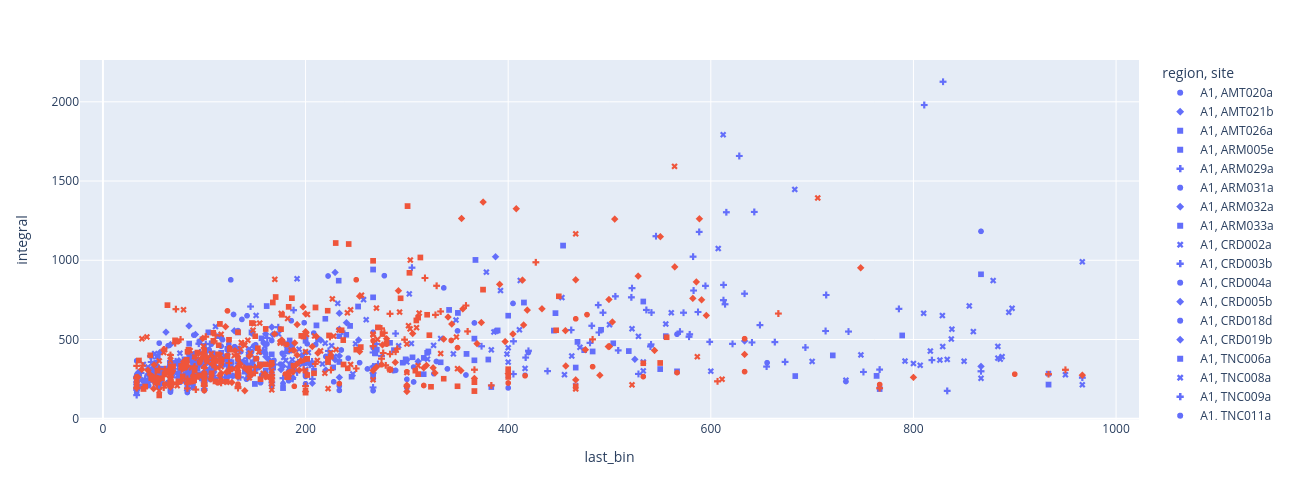

In [4]:
toplot = df.groupby(['id','site', 'region', 'metric']).agg(value=('value', np.mean)).reset_index()
toplot = toplot.pivot_table(index=['id', 'site', 'region'], columns='metric', values='value').reset_index()
fig = px.scatter(toplot, x='last_bin', y='integral', color='region', symbol='site')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# aggregating by site

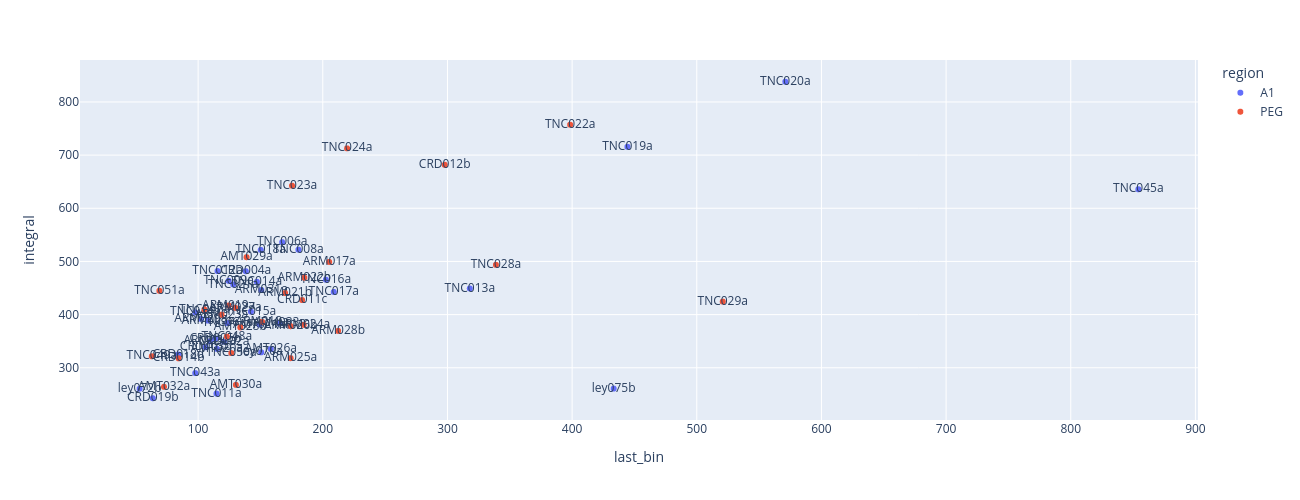

In [5]:
toplot = df.groupby(['site', 'region', 'metric']).agg(value=('value', np.mean)).reset_index()
toplot = toplot.pivot_table(index=['site', 'region'], columns='metric', values='value').reset_index()
fig = px.scatter(toplot, x='last_bin', y='integral', color='region', text='site')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# quick boxplot of parameters by region

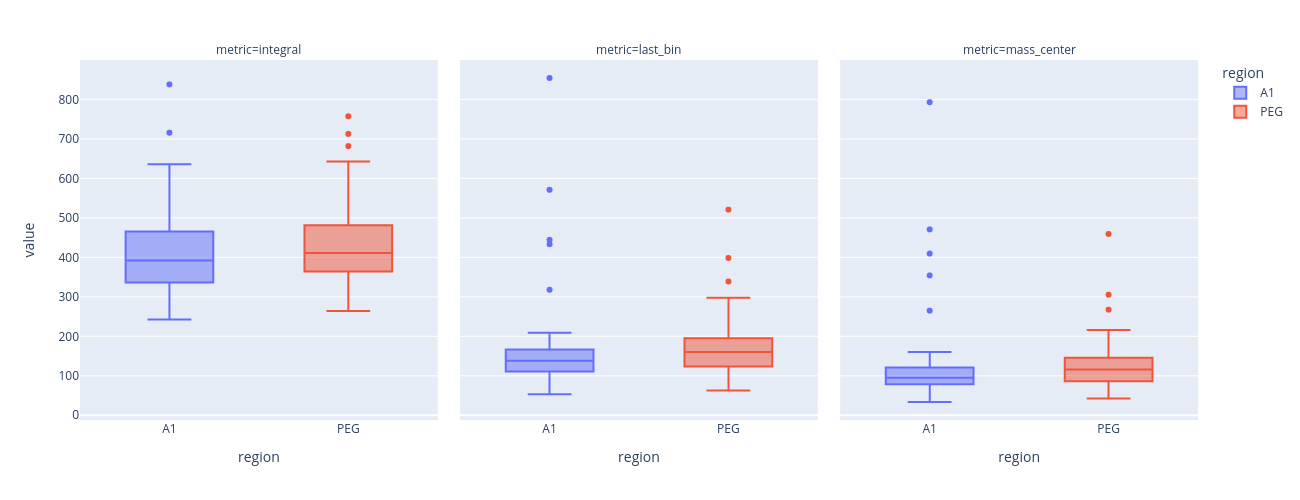

In [6]:
toplot = df.groupby(['site', 'region', 'metric']).agg(value=('value', np.mean)).reset_index()
fig = px.box(toplot, x='region', y='value', color='region', facet_col='metric')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# similar but with PCA

In [7]:
sel_met = ['integral', 'mass_center', 'last_bin']
df_pca = DF_PCA.query(f"metric in {sel_met} and source == 'real' and mult_comp_corr == 'bf_cp' and "
              f"value > 0")
# takes only the nth pc
df_pca = df_pca.loc[df_pca.id.str.endswith('PC-1'),:]
df_pca.head()

,id,context_pair,probe,value,metric,mult_comp_corr,analysis,site,region,source,cluster_threshold,stim_count
36,AMT020a-PC-1,00_03,1,533.335761,mass_center,bf_cp,PCA,AMT020a,A1,real,0.05,4
72,AMT020a-PC-1,01_02,1,19.884145,mass_center,bf_cp,PCA,AMT020a,A1,real,0.05,4
198,AMT020a-PC-1,00_02,2,132.101437,mass_center,bf_cp,PCA,AMT020a,A1,real,0.05,4
252,AMT020a-PC-1,01_02,2,66.57587,mass_center,bf_cp,PCA,AMT020a,A1,real,0.05,4
306,AMT020a-PC-1,02_03,2,94.379247,mass_center,bf_cp,PCA,AMT020a,A1,real,0.05,4


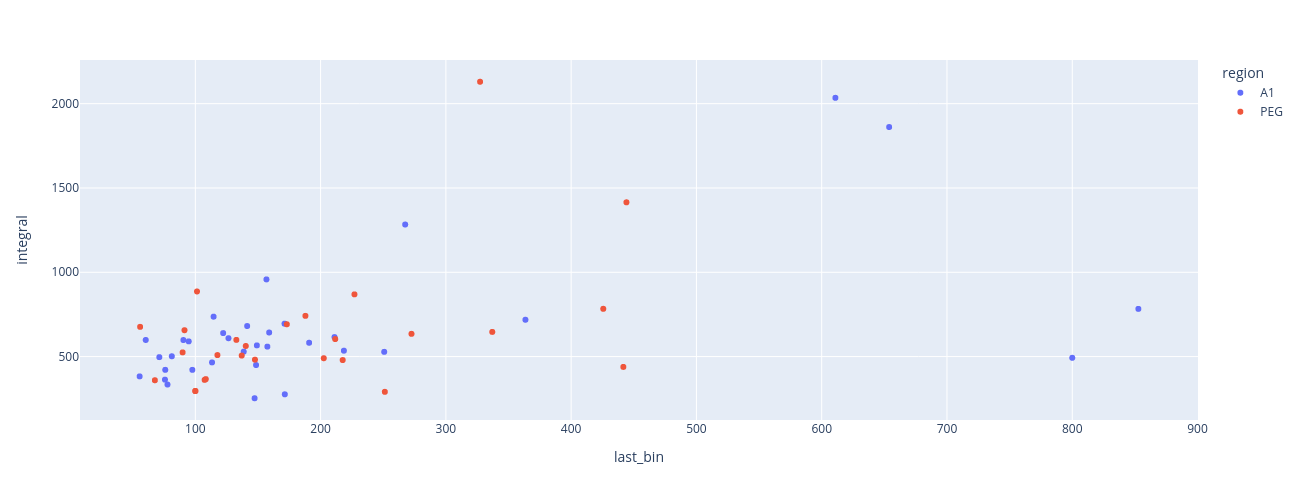

In [8]:
toplot = df_pca.groupby(['id', 'region', 'metric']).agg(value=('value', np.mean)).reset_index()
toplot = toplot.pivot_table(index=['id', 'region'], columns='metric', values='value').reset_index()
fig = px.scatter(toplot, x='last_bin', y='integral', color='region',hover_name='id')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

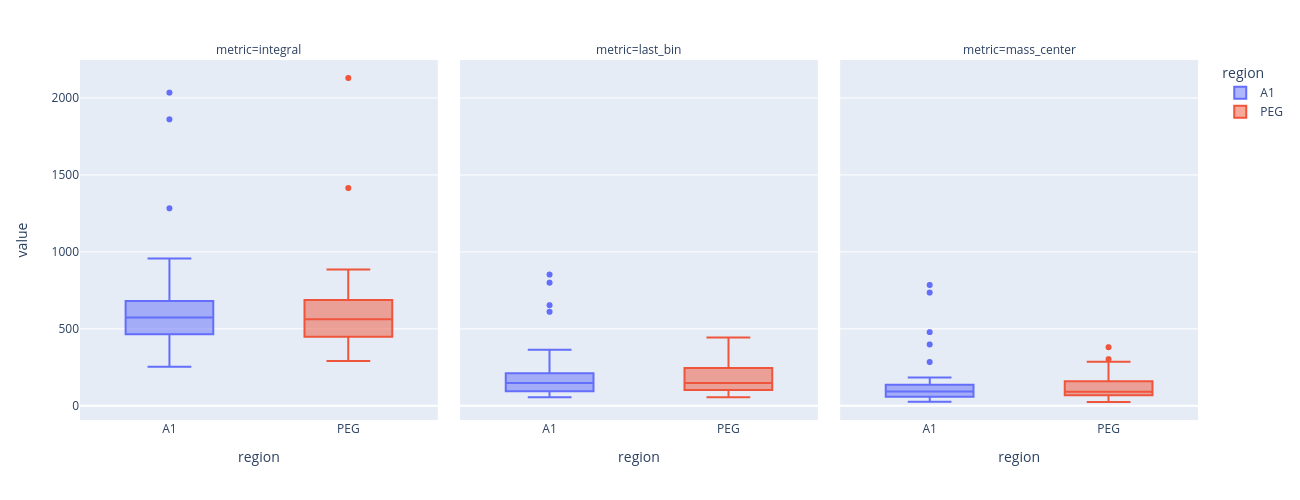

In [9]:
toplot = df_pca.groupby(['id', 'region', 'metric']).agg(value=('value', np.mean)).reset_index()
fig = px.box(toplot, x='region', y='value', color='region', facet_col='metric')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# Regression between site mean and first PC

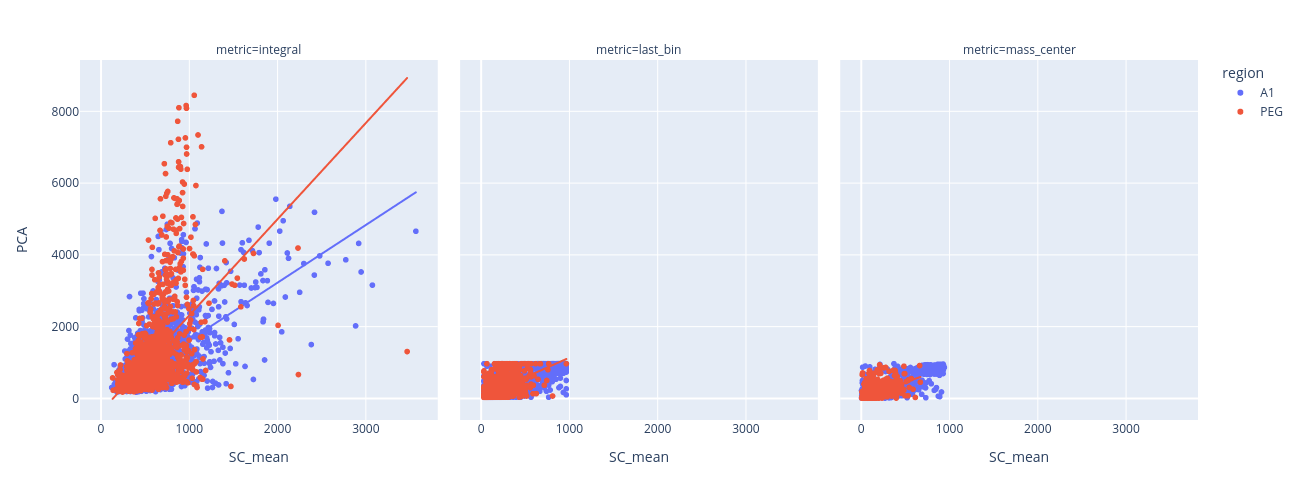

In [14]:
left = df.groupby(['site', 'region', 'metric', 'context_pair', 'probe']
                  ).agg(value=('value', np.mean)).reset_index()
right = df_pca.groupby(['site', 'region', 'metric', 'context_pair', 'probe']
                       ).agg(value=('value', np.mean)).reset_index()

toplot = pd.merge(left, right, on=['site', 'region', 'metric', 'context_pair', 'probe']
                  ).rename(columns={'value_x':'SC_mean', 'value_y': 'PCA'})

fig = px.scatter(toplot, x='SC_mean', y='PCA', color='region', facet_col='metric', trendline='ols')
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

# conclussion
for now I can say that something looks fishy with some of the A1 site, and that the PCA somewhat recapitulates what
the site mean says